# Hierarchical Linear Regression in Edward2

In [14]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
import warnings

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    from tensorflow_probability import edward2 as ed

data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values

The relevant part of the data we will model looks as follows:

In [16]:
data[['county', 'log_radon', 'floor']].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


In [17]:
def model(data):
    county_idx = data['county_code'].values
    
    # Set up random effects.
    grp_mu_intercept = ed.Normal(
      loc=0.,
      scale=1.,
      name="grp_mu_intercept")
    
    grp_sd_intercept = tf.exp(ed.Normal(
      loc=0.,
      scale=1.,
      name="grp_sd_intercept"))

    grp_mu_slope = ed.Normal(
      loc=0.,
      scale=1.,
      name="grp_mu_slope")
    
    grp_sd_slope = tf.exp(ed.Normal(
      loc=0.,
      scale=1.,
      name="grp_sd_slope"))

    intercept_raw = ed.Normal(
        loc=tf.zeros(len(data.county.unique())),
        scale=tf.ones(len(data.county.unique())),
        name='intercept',
    )
    
    slope_raw = ed.Normal(
        loc=tf.zeros(len(data.county.unique())),
        scale=tf.ones(len(data.county.unique())),
        name='slope',
    )
    
    # Centered
    intercept = intercept_raw + grp_mu_intercept * grp_sd_intercept
    slope = slope_raw + grp_mu_slope * grp_sd_slope
    
    radon = ed.Normal(
        loc=(tf.gather(intercept, county_idx) +
             tf.gather(slope, county_idx) * data.floor.values),
        scale=1.,
        name='radon',
    )

    return radon

# Wrap model in a template. All calls to the model template will use the same
# TensorFlow variables.
model_template = tf.make_template("model", model)

In [18]:
log_joint = ed.make_log_joint_fn(model_template)

def target_log_prob_fn(grp_mu_intercept,
                       grp_sd_intercept,
                       grp_mu_slope,
                       grp_sd_slope,
                       intercept,
                       slope,                       
                      ):
    """Unnormalized target density as a function of states."""
    return log_joint(
        data=data,
        grp_mu_intercept=grp_mu_intercept,
        grp_sd_intercept=grp_sd_intercept,
        grp_mu_slope=grp_mu_slope,
        grp_sd_slope=grp_sd_slope,      
        intercept=intercept,
        slope=slope,
        radon=data.log_radon.values)

In [19]:
grp_mu_intercept = tf.get_variable('grp_mu_intercept', ())
grp_sd_intercept = tf.get_variable('grp_sd_intercept', ())
grp_mu_slope = tf.get_variable('grp_mu_slope', ())
grp_sd_slope = tf.get_variable('grp_sd_slope', ())    
intercept = tf.get_variable('intercept', len(data.county.unique()))
slope = tf.get_variable('slope', len(data.county.unique()))

In [20]:
current_state = [grp_mu_intercept, grp_sd_intercept, grp_mu_slope, grp_sd_slope, intercept, slope]

In [21]:
ndims = 4 + 2 * len(data.county.unique())

In [28]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    with sess.as_default():
        states, kernel_results = tfp.mcmc.sample_chain(
          num_results=10000,
          current_state=current_state,
          kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob_fn,
            step_size=0.01,
            num_leapfrog_steps=8),
          num_burnin_steps=500)

        trace = {rv.name: states[i].eval() for i, rv in enumerate(current_state)}

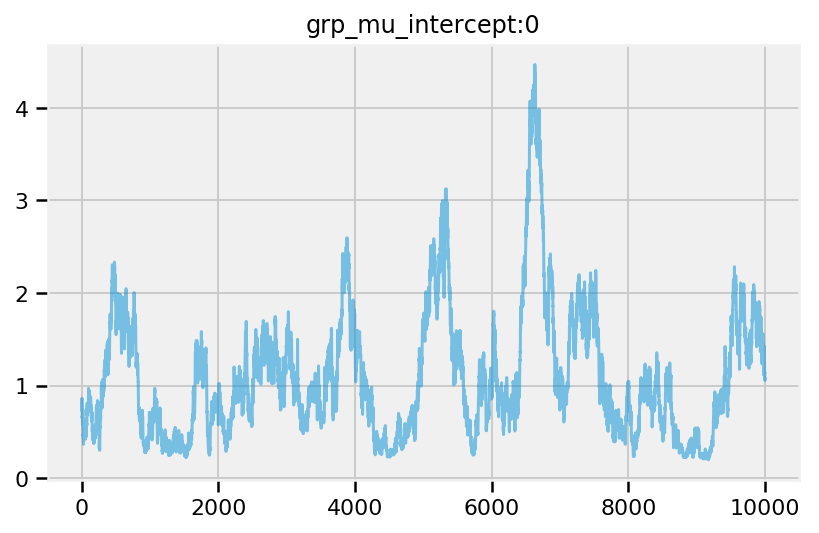

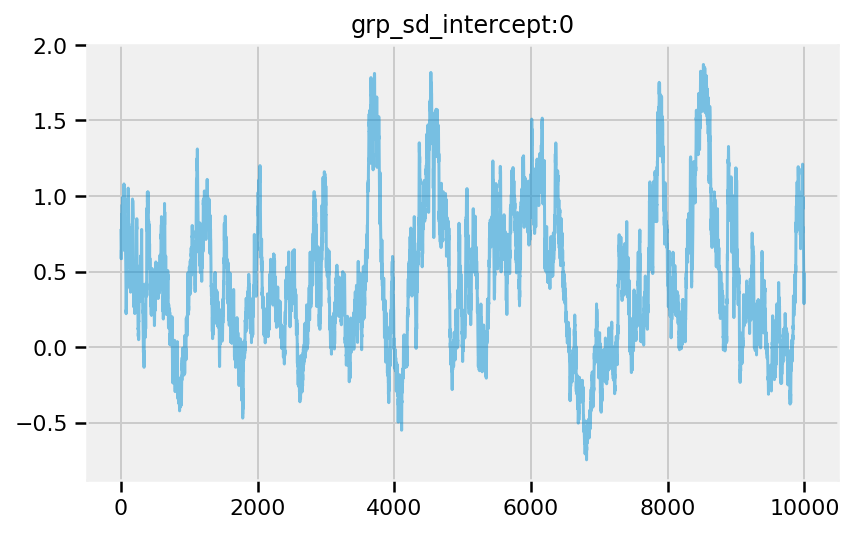

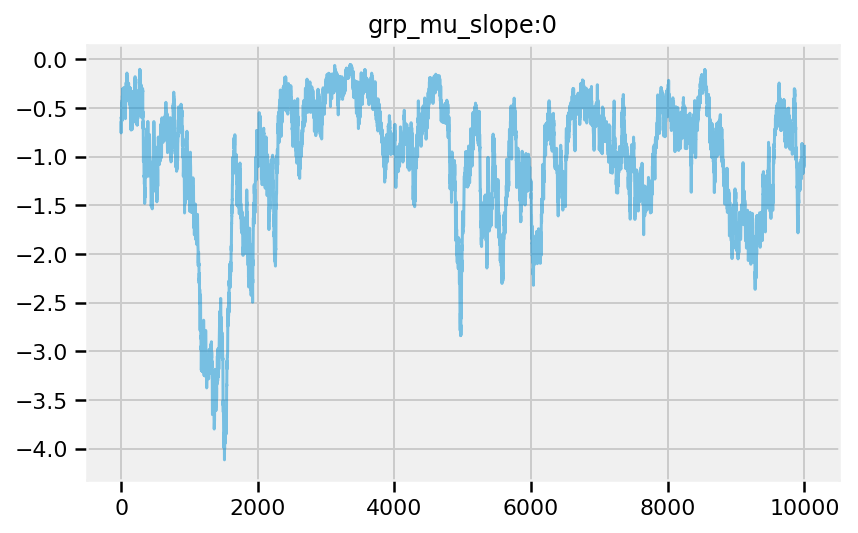

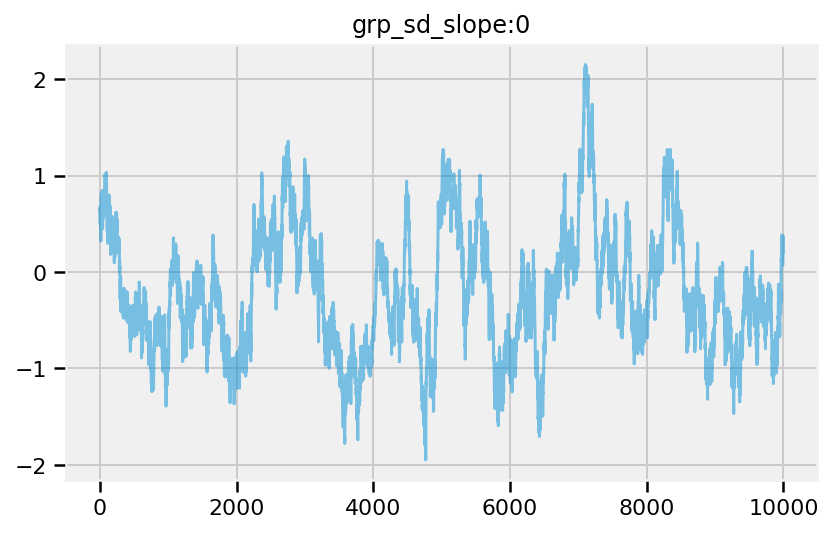

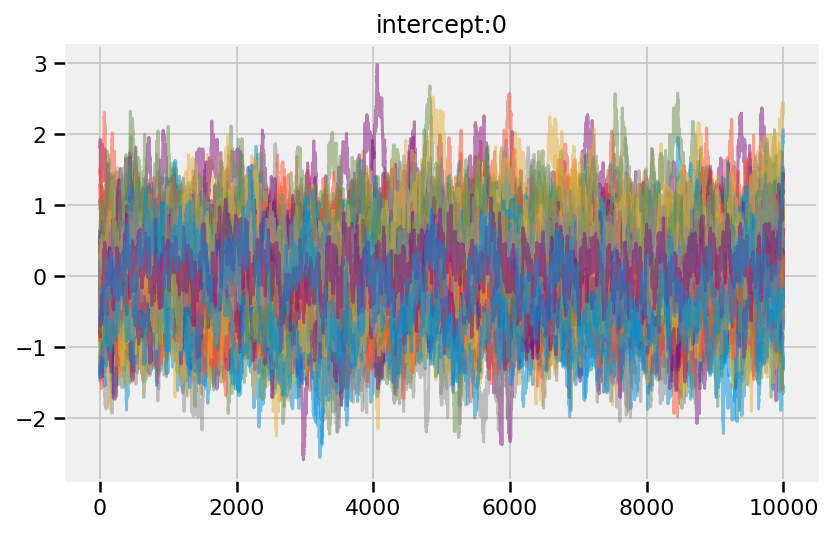

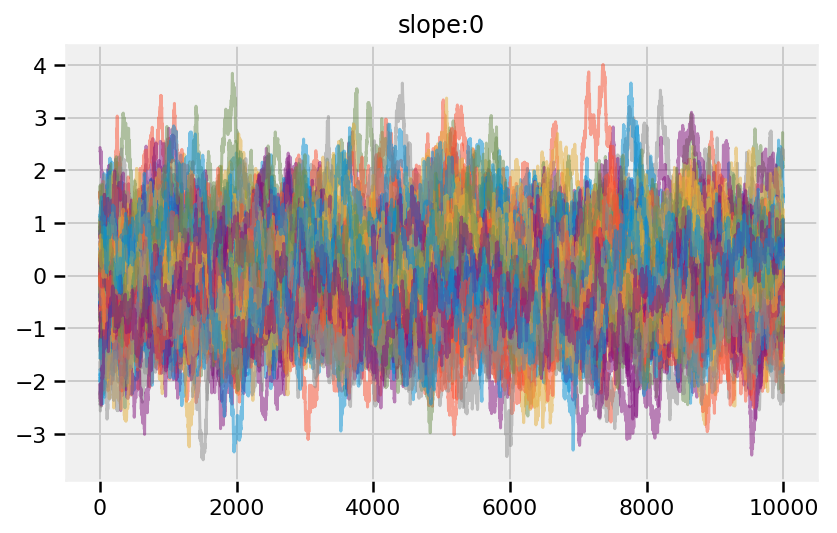

In [29]:
for name, tr in trace.items():
    plt.figure()
    plt.plot(tr, alpha=.5)
    plt.title(name)